In [11]:
import re
import nltk
import spacy
import json
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
from sklearn.metrics import classification_report

In [12]:
nlp = spacy.load("en_core_web_sm")
# Download necessary resources for text processing
nltk.download('stopwords')


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\DELL\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [13]:
# Function to refine and standardize text for processing
def refine_text(input_text):
    cleaned_text = re.sub(r'[^\w\s]', '', input_text.lower())
    return cleaned_text

def get_conversation_id(conversation):
    conversation_id = conversation.get('ConversationID', None)  
    if conversation_id:
        return conversation_id
    return conversation_id

In [14]:
def process_data_from_files(file_paths):
    processed_texts = []
    for path in file_paths:
        with open(path, 'r') as data_file:
            data_content = json.load(data_file)
            for source in data_content['Sources']:
                for sharing in source.get('ChatgptSharing', []):
                    for conversation in sharing.get('Conversations', []):
                        prompt = conversation.get('Prompt', '')
                        cleaned_prompt = refine_text(prompt)
                        processed_texts.append((cleaned_prompt, conversation))  # Storing prompt and conversation info
    return processed_texts

In [15]:
def identify_contextual_prompts(processed_texts):
    contextual_prompts = []
    for idx, (prompt, conversation) in enumerate(processed_texts):
        pronouns = [token.text.lower() for token in nlp(prompt) if token.pos_ == 'PRON']
        if any(pronoun in ['it', 'they', 'he', 'she'] for pronoun in pronouns):
            contextual_prompts.append((prompt, idx))
        temporal_phrases = ['yesterday', 'earlier', 'after that', 'previously']
        if any(phrase in prompt.lower() for phrase in temporal_phrases):
            contextual_prompts.append((prompt, idx))
        if idx > 0:
            previous_doc = nlp(processed_texts[idx - 1][0])
            if nlp(prompt).similarity(previous_doc) > 0.7:
                contextual_prompts.append((prompt, idx))
            for ent in previous_doc.ents:
                if ent.label_ in ['PERSON', 'ORG', 'DATE', 'GPE']:
                    if ent.text.lower() in prompt.lower():
                        contextual_prompts.append((prompt, idx))
    return contextual_prompts

def identify_multi_turn_prompts(processed_texts):
    multi_turn = []
    for idx, (prompt, conversation) in enumerate(processed_texts):
        # Criteria for Multi-turn Prompts
        if idx > 0:
            current_conversation_id = get_conversation_id(conversation)
            previous_conversation_id = get_conversation_id(processed_texts[idx - 1][1])

            if current_conversation_id == previous_conversation_id:
                previous_prompt = processed_texts[idx - 1][0]
                # Add logic to identify multi-turn prompts within the same conversation
                if len(prompt.split()) > len(previous_prompt.split()):  # Longer prompts indicating continuity
                    multi_turn.append((prompt, idx))
                elif 'how' in prompt.lower() or 'why' in prompt.lower():  # Complex queries indicating multi-turn
                    multi_turn.append((prompt, idx))
                elif prompt.lower().startswith(('and', 'but', 'also', 'however')):  # Sequel phrases indicating continuation
                    multi_turn.append((prompt, idx))
    return multi_turn

def classify_prompts(processed_texts):
    single_turn = []
    multi_turn = []
    contextual = []
    for idx, (prompt, _) in enumerate(processed_texts):
        words_count = len(prompt.split())
        if words_count <= 3:
            single_turn.append((prompt, idx))
        elif 3 < words_count <= 10:
            multi_turn.append((prompt, idx))
        else:
            contextual.append((prompt, idx))
    return single_turn, multi_turn, contextual

In [16]:
def print_samples_category(category, category_name):
    print(f"Samples for {category_name} category:")
    samples = random.sample(category, 5)  # Select random 10 samples for the category
    for i, sample in enumerate(samples, start=1):
        print(f"{i}. {sample[0]}\n")

In [18]:
data_files = ['discuss.json', 'issues.json', 'commit.json','pr_sharings.json','hn_sharings.json','file_sharing.json']

processed_texts = process_data_from_files(data_files)

identified_contextual_prompts = identify_contextual_prompts(processed_texts)

single_turn, multi_turn, contextual = classify_prompts(processed_texts)

identified_multi_turn_prompts = identify_multi_turn_prompts(processed_texts)

texts = [text[0] for text in processed_texts]
labels = ['Single-turn' if idx in [i[1] for i in single_turn] else
          'Multi-turn' if idx in [i[1] for i in multi_turn] else
          'Contextual' for idx, _ in enumerate(processed_texts)]


print_samples_category(single_turn, 'Single-turn')
print("\n")
print_samples_category(multi_turn, 'Multi-turn')
print("\n")
print_samples_category(contextual,'Contextual')

C:\Users\DELL\AppData\Local\Temp\ipykernel_19104\3898851607.py:12: UserWarning: [W007] The model you're using has no word vectors loaded, so the result of the Doc.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  if nlp(prompt).similarity(previous_doc) > 0.7:
C:\Users\DELL\AppData\Local\Temp\ipykernel_19104\3898851607.py:12: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  if nlp(prompt).similarity(previous_doc) > 0.7:


Samples for Single-turn category:
1. are you ok

2. cat the file

3. continue

4. hello hello 

5. in economics 



Samples for Multi-turn category:
1. i am happy for you but this is very serious


2. can u give me the full code please thank you

3. why doesnt apple add cellular service to laptops

4. can you try lightgbm 

5. can you translate it to english please



Samples for Contextual category:
1. i dont like any of these i want it to look like bauhaus or some new artsy gallery

2. i want to create a customcommand in cypress to write dinamycally a new fixture with this function

cypresscommandsaddgeneratefixture   
  cywritefilecypressfixturestorrentssampletxt hello3

  cyreadfilecypressfixturestorrentssampletxt utf8thenlogo  

    const buf  bufferfromsome file content
    bufname  some file name

    createtorrentbuf err torrent  

      cywritefilecypressfixturestorrentssampletxttorrenterrortxt buf utf8

      let buffer  cypressbufferfromtorrent

      if err 
        cywrite

In [19]:
# Text vectorization
vectorizer = CountVectorizer(stop_words='english')
X = vectorizer.fit_transform(texts)

# Split data for training and testing
X_train, X_test, y_train, y_test = train_test_split(X, labels, test_size=0.2, random_state=42)

# Train Logistic Regression model
logreg = LogisticRegression(max_iter=1000)
logreg.fit(X_train, y_train)

# Predictions on test set
y_pred = logreg.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy of the Logistic Regression model: {accuracy:.2%}")

Accuracy of the Logistic Regression model: 88.63%


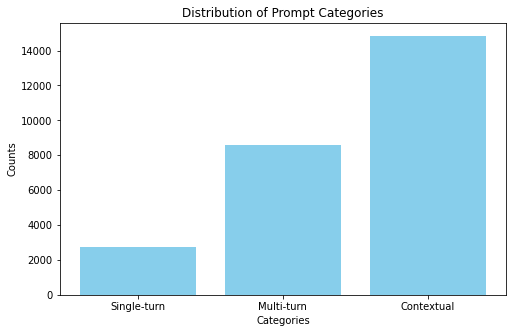

In [20]:
def plot_category_counts(single_turn, multi_turn, contextual):
    categories = ['Single-turn', 'Multi-turn', 'Contextual']
    counts = [len(single_turn), len(multi_turn), len(contextual)]
    plt.figure(figsize=(8, 5))
    plt.bar(categories, counts, color=['skyblue'])
    plt.xlabel('Categories')
    plt.ylabel('Counts')
    plt.title('Distribution of Prompt Categories')
    plt.show()
plot_category_counts(single_turn, multi_turn, contextual)

In [21]:
# User input to classify a prompt
user_prompt = input("Enter a prompt: ")
cleaned_user_prompt = refine_text(user_prompt)

# Vectorize user input prompt and predict its category
user_input_vectorized = vectorizer.transform([cleaned_user_prompt])
predicted_category = logreg.predict(user_input_vectorized)[0]

# Display the category based on classification
if predicted_category == 'Single-turn':
    print("Category: Single-turn")
elif predicted_category == 'Multi-turn':
    print("Category: Multi-turn")
elif predicted_category == 'Contextual':
    print("Category: Contextual")
else:
    print("Unable to classify the prompt")


Enter a prompt: I'm optimizing a Python function for large data sets. Currently, it's slow with numpy arrays. Any suggestions for faster processing?
Category: Contextual


In [22]:
# Print classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

  Contextual       0.95      0.92      0.94      2892
  Multi-turn       0.83      0.84      0.84      1724
 Single-turn       0.76      0.83      0.79       618

    accuracy                           0.89      5234
   macro avg       0.85      0.87      0.86      5234
weighted avg       0.89      0.89      0.89      5234

